# calculate History term
In this  notebook the history force is calculated given by: 
$$ \mathbf{F}_{history}  = 3\pi \nu_f d \int_{0}^t K(t-s)\frac{d}{ds} (\mathbf{u}_p(s) -\mathbf{u}_s(s)) ds $$ 
with the "Kernel" K depends on the particle Reynolds number, for small particle Reynolds number we have the Basset version:
$$ K_{Basset} = \frac{d}{2 \pi \sqrt{t-s}}$$
For larger particle Reynolds number different the history kernel of Mei1992 is used 
$$ \mathbf{F}_{history}  = 3\pi \nu_f d \int_{0}^t K(t-s)\frac{d}{ds} (\mathbf{u}_p(s) -\mathbf{u}_s(s)) ds $$ 
where there are slightly differnt values for coefficients c1 and c2 from literature:
- Mei 1992 : c1 = 2, c2 = 0.1015
- Kim 1996 : c1 = 2.5 c2 = 0.126
- Dorgan 2007: c1 = 2.5, c2 = 0.2
For larger Reynolds numbers there is a crossover between basset like decay (as ^0.5) at short time scales and squared  
decay (^2) on long timescales. The timescale associated with this is $\tau_h$ and makes that the history decays faster  
to zero for larger particles reynolds numbers, this allows to use a finite window to calculate the history term from  
time $t-\tau_h$ to current time $t$.

In [2]:
# import needed packages

#update reading in packages when rerunning this cell
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
import scipy.special as sc
from datetime import datetime, timedelta
from scipy.interpolate import CubicSpline # maybe not needed
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/src")
from particle_characteristics_functions import stokes_relaxation_time, Re_particle, factor_drag_white1991, diffusion_time, slip_force
from history_term_functions import Basset_kernel, Mei1992_kernel, history_timescale, Daitche, Hinsberg, f_Mei1992, History_Force_Hinsberg_Mei_kernel, History_Force_Hinsberg_Basset_kernel
from analysis_functions_xr import derivative_backward
from analysis_functions import make_PDF
plt.style.use('../python_style_Meike.mplstyle')

In [3]:
# analytical test functions

def dUslip_dt_cos(t):
    return np.cos(t,dtype = np.float128)
    
def Basset_analytical_cos(t):
    
    S, C = sc.fresnel(np.sqrt(2 * t / np.pi))
    return np.sqrt(2 * np.pi ) * (np.cos(t) * C + np.sin(t) * S )

    
def dUslip_dt_tt(t):
    return t*t
    
def Basset_analytical_tt(t):
    return 2/15 * np.sqrt(t) * 8 * t *t 


In [4]:
# constants
Rearth = 6371 * 10**3 # in m,
deg2rad = np.pi / 180.
sec_in_min = 60
min_in_hour = 60
sec_in_hour = sec_in_min * min_in_hour


rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water
diameter =0.2 # m
B=0.68
tau_p = stokes_relaxation_time(diameter, kinematic_viscosity_water, B)
S = 1/12 * diameter* diameter/kinematic_viscosity_water

cs = {'Mei':{'c1':2,'c2':0.105},
             'Kim':{'c1':2.5,'c2':0.126},
             'Dorgan':{'c1':2.5,'c2':0.2}}

## Compare numerical solution Basset history term for idealized flow
Comparing with Fig 4 in Moreno-Casas, Bombardelli 2016

In [5]:
Daitche_analytical_tt=[]
Hinsberg_analytical_tt=[]
Daitche_analytical_cos=[]
Hinsberg_analytical_cos=[]


T = 50 * np.pi
Nlist =  np.array([243,729,2187,6561,19683,59049,177411,1594323])
# Nlist =  np.arange(100,100000,100)
for N in Nlist:
    dt = np.float128(T/(N))
    tlist = np.arange(0,T+0.1*dt,dt)
    dudt_tt =dUslip_dt_tt(tlist)
    Daitche_analytical_tt.append(Daitche(dudt_tt,N,dt))
    Hinsberg_analytical_tt.append(Hinsberg(dudt_tt,N,dt))

    dudt_cos =dUslip_dt_cos(tlist)
    Daitche_analytical_cos.append(Daitche(dudt_cos,N,dt))
    Hinsberg_analytical_cos.append(Hinsberg(dudt_cos,N,dt))
analytical_tt =Basset_analytical_tt(T)
analytical_cos =Basset_analytical_cos(T)


 




Text(0, 0.5, 'relative error')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


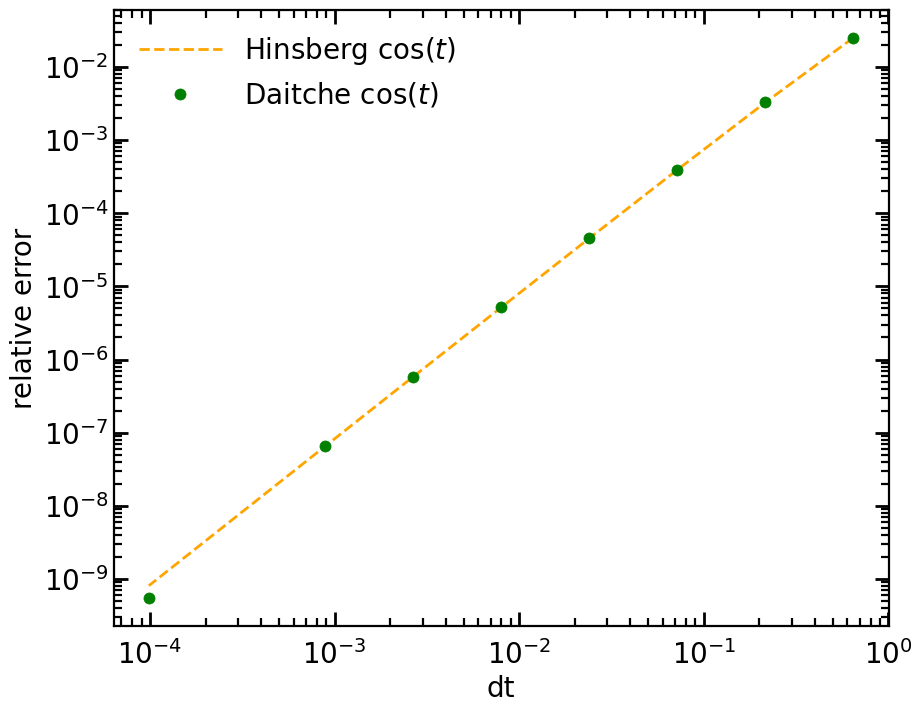

In [6]:
fig, ax = plt.subplots()
ax.plot(T/(Nlist), np.abs(Hinsberg_analytical_cos-analytical_cos)/analytical_cos,'--',color='orange')
ax.plot(T/(Nlist), np.abs(Daitche_analytical_cos-analytical_cos)/analytical_cos,'o',color='green')


# ax.plot(T/(Nlist), np.abs(Hinsberg_analytical_tt-analytical_tt)/analytical_tt,'--',color='navy')
# ax.plot(T/(Nlist), np.abs(Daitche_analytical_tt-analytical_tt)/analytical_tt,'o',color='firebrick')

ax.legend(['Hinsberg $\\cos(t)$','Daitche $\\cos(t)$','Hinsberg $t^2$','Daitche $t^2$',])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('dt')

ax.set_ylabel('relative error')
# ax.set_ylim(10**(-14),10**0)
# ax.set_xlim(10**(-4),2*10**(-1))


### Comparing Basset history term and Mei history term for idealized flows

In [7]:
N = 500
T=50 * np.pi
dt = T/N
c1 = cs['Mei']['c1']
c2 = cs['Mei']['c2']

Rep = 400
S = 1 *  diameter* diameter/kinematic_viscosity_water


tlist = np.arange(0,T+0.1*dt,dt)
dudt_cos =dUslip_dt_cos(tlist)

Nwindow = 50


fmei = f_Mei1992(dudt_cos, T, c1, c2, Rep ,N ,dt ,S)
fmei_window = np.array(fmei)[-(Nwindow + 1):]
fbasset_window = np.array(dudt_cos)[-(Nwindow + 1):]
# fmei_window = [fmei[k] if k > k0 else 0 for k in range(0,N+1,1)]


daitche_Mei = Daitche(fmei,N,dt)
daitche_basset = Daitche(dudt_cos,N,dt)
Hinsberg_Mei = Hinsberg(fmei,N,dt)
Hinsberg_Mei_window = Hinsberg(fmei_window,Nwindow,dt)
Hinsberg_Basset_window = Hinsberg(fbasset_window,Nwindow,dt)

Hinsberg_basset = Hinsberg(dudt_cos,N,dt)
# print(daitche_basset)
# print(daitche_Mei)

print(f'Basset(N={N}) = {Hinsberg_basset} \t Basset(Nwindow ={Nwindow}) = {Hinsberg_Basset_window}')
print(f'Mei (N={N}) = {Hinsberg_Mei} \t Mei(Nwindow ={Nwindow}) = {Hinsberg_Mei_window}')



Basset(N=500) = 1.244668494709721 	 Basset(Nwindow =50) = 1.2527717631255217
Mei (N=500) = 1.2538103639979195 	 Mei(Nwindow =50) = 1.2623142730850825


## checking implementation of history force unitless kernel
Below I compare the implementation of the unitless history kernel (from Dorgan 2007) against the standard version used by Hinsberg/Daitche (checked above) 


In [11]:
# check force (in Newton!)
T = 50 * np.pi
N = 54564
dt = T/N
Rep = 400
c1 = cs['Mei']['c1']
c2 = cs['Mei']['c2']
S =  diameter* diameter/kinematic_viscosity_water
tlist = np.arange(0,T+0.1*dt,dt)
dudt_cos =dUslip_dt_cos(tlist)

# Nwindow = 50

fmei = f_Mei1992(dudt_cos, T, c1, c2, Rep ,N ,dt ,S)

Hinsberg_unit1 = 3/2 * rho_water *  diameter*diameter* np.sqrt(np.pi * kinematic_viscosity_water) * Hinsberg(fmei,N,dt)
Hinsberg_unit2 =  History_Force_Hinsberg_Mei_kernel(dudt_cos,T,c1,c2,Rep,N,dt,diameter, kinematic_viscosity_water, rho_water)

print(Hinsberg_unit1)
print(Hinsberg_unit2)


0.16138055476424623863
0.16138055476424626948


# Calculate history term for simulation data
Use force as unit as I am not sure about how to handle the history term in the slow manifold MR derivation.

In [12]:
# need to find correct timescales
tau_diff = diffusion_time(diameter,kinematic_viscosity_water) # in sec
print(f'tau_diff = {tau_diff:.2f} s') 
tau_H = history_timescale(Rep,tau_diff) # in sec
print(f'tau_H = {tau_H:.2f} s') #7.5 min

tau_diff = 29134.75 s
tau_H = 449.82 s


# calculate basset history term for high time resolution data
We use data that ran for 24 h with output every 5 min to calculate
the basset history kernel and term and invastigate its sensitivity
to total timewindow and timesteps used. 

In [10]:
particle_types = ['inertial','inertial_SM','inertial_drag_Rep','inertial_SM_drag_Rep']
legendnames=['MR Stokes drag','MRSM Stokes drag','MR Re$_p$ drag','MRSM Re$_p$ drag']

In [124]:
output_dir = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/test_history_term/')
file_base = (output_dir+'{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_dt_{dt_seconds:04d}.zarr')

# settings
starttime = datetime(2023,9,1,0,0,0)
runtime = timedelta(hours =2)
endtime = starttime + runtime
loc = 'NWES'
land_handling = 'anti_beaching'
coriolis = True
B = 0.68
tau = 2759.97
Rep = 457
nparticles_select =1000
chunck_time=100
data_short={}
dt_write_list = [timedelta(seconds =5),timedelta(seconds =10)]#,timedelta(seconds =60),timedelta(seconds =300)]
particle_types = ['inertial_drag_Rep','inertial_Rep_constant']#,'inertial','inertial_Rep_constant','inertial_SM_drag_Rep','inertial_SM','inertial_SM_Rep_constant']
for pt in particle_types:
    data_short[pt]={}
    for dt_write in dt_write_list:
          file = file_base.format(loc = loc,
                        y_s = starttime.year,
                        m_s = starttime.month,
                        d_s = starttime.day,
                        y_e = endtime.year,
                        m_e = endtime.month,
                        d_e = endtime.day,
                         land_handling = land_handling,
                         cor_on = coriolis,
                         dt_seconds = dt_write.seconds,
                         particle_type = pt,
                         B = int(B * 1000),
                         tau = int(tau))



          ds = xr.open_dataset(file,
          engine='zarr',
                                             chunks={'trajectory':nparticles_select, 'obs':chunck_time},
                                             drop_variables=['B','tau','z'],
                                             decode_times=False) #,decode_cf=False)
          Uslip = np.sqrt(ds.uslip**2 + ds.vslip**2) 
          ds = ds.assign(Uslip = Uslip)
          data_short[pt][dt_write.seconds]=ds
          dt=10.0 # seconds. 
          duslipdt = derivative_backward(data_short[pt][dt_write.seconds].uslip,dt)
          dvslipdt = derivative_backward(data_short[pt][dt_write.seconds].vslip,dt)    

          dufluiddt = derivative_backward(data_short[pt][dt_write.seconds].ufluid,dt)
          dvfluiddt = derivative_backward(data_short[pt][dt_write.seconds].vfluid,dt)   

          duparticledt = derivative_backward(data_short[pt][dt_write.seconds].uparticle,dt)
          dvparticledt = derivative_backward(data_short[pt][dt_write.seconds].vparticle,dt)   

          data_short[pt][dt_write.seconds] = data_short[pt][dt_write.seconds].assign(duslipdt = duslipdt)
          data_short[pt][dt_write.seconds] = data_short[pt][dt_write.seconds].assign(dvslipdt = dvslipdt)


          data_short[pt][dt_write.seconds] = data_short[pt][dt_write.seconds].assign(duparticledt = duparticledt)
          data_short[pt][dt_write.seconds] = data_short[pt][dt_write.seconds].assign(dvparticledt = dvparticledt)
                                                                                     

          data_short[pt][dt_write.seconds] = data_short[pt][dt_write.seconds].assign(dufluiddt = dufluiddt)
          data_short[pt][dt_write.seconds] = data_short[pt][dt_write.seconds].assign(dvfluiddt = dvfluiddt)


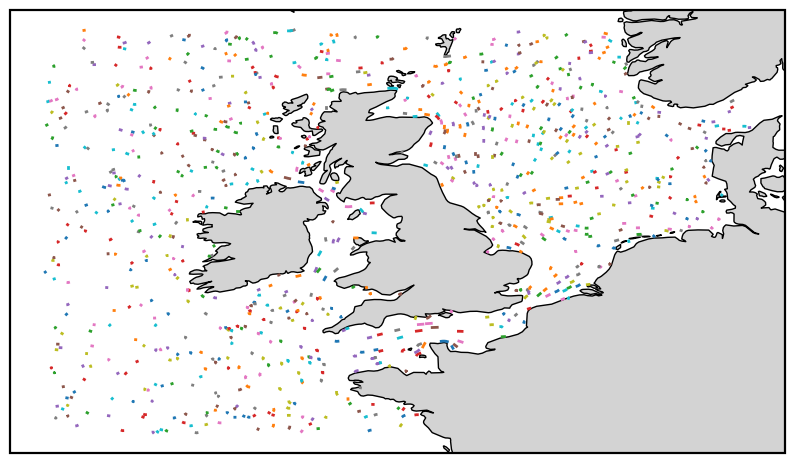

In [125]:
pt = 'inertial_drag_Rep'
dt_write = timedelta(seconds=10).seconds
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(data_short[pt][dt_write].lon[:,:].T,data_short[pt][dt_write].lat[:,:].T,'-');

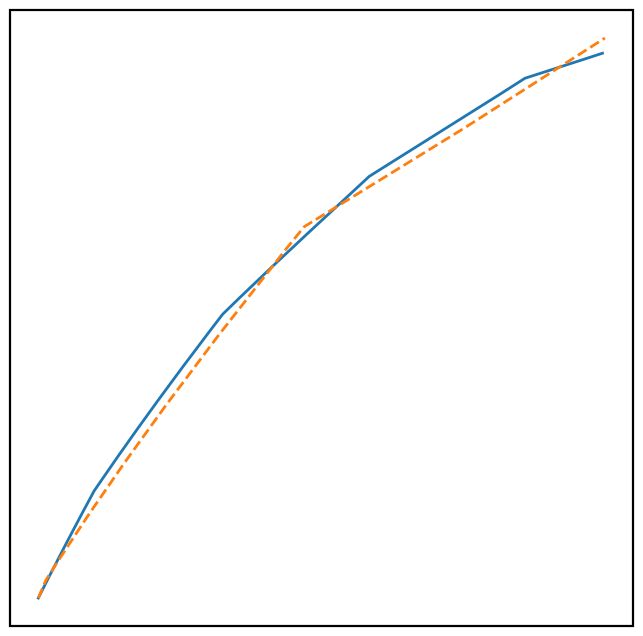

In [137]:
pt = 'inertial_drag_Rep'
dt_write = timedelta(seconds=10).seconds
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(data_short[pt][10].lon[2,:].T,data_short[pt][10].lat[2,:].T,'-');
ax.plot(data_short[pt][5].lon[2,:].T,data_short[pt][5].lat[2,:].T,'--');

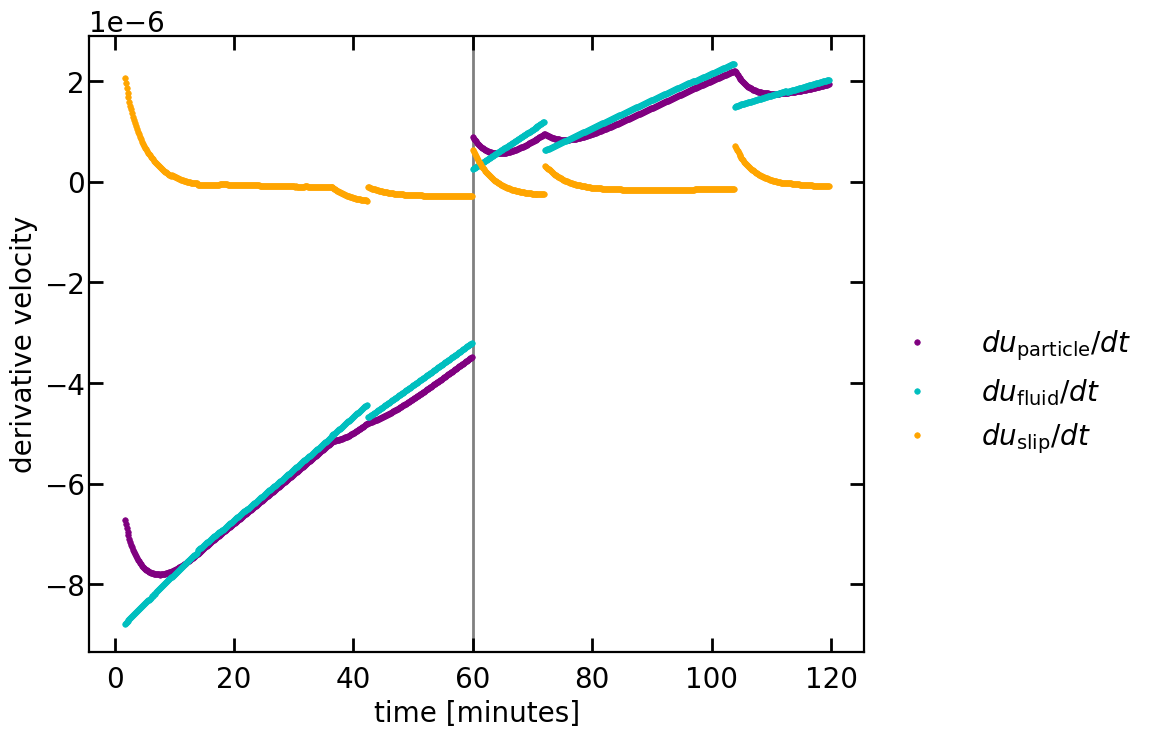

In [162]:
# plot values
id = 2
dt_write =10
fig,ax=plt.subplots()
for pt in ['inertial_Rep_constant']:
    
    ax.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].duparticledt[id,10:],'.',color='purple')
    ax.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].dufluiddt[id,10:],'.',color='c')

    ax.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].duslipdt[id,10:],'.',color='orange')
    # ax.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].facc_lon[id,10:],'.')
ax.legend(['$d u_{\\mathrm{particle}}/dt$','$d u_{\\mathrm{fluid}} / dt$','$d u_{\\mathrm{slip}}/dt$'],loc=(1.,0.3))

# ax.set_yscale('log')
ax.set_xlabel('time [minutes]')
ax.set_ylabel('derivative velocity')

ax.axvline(60,zorder=-5,color='grey')

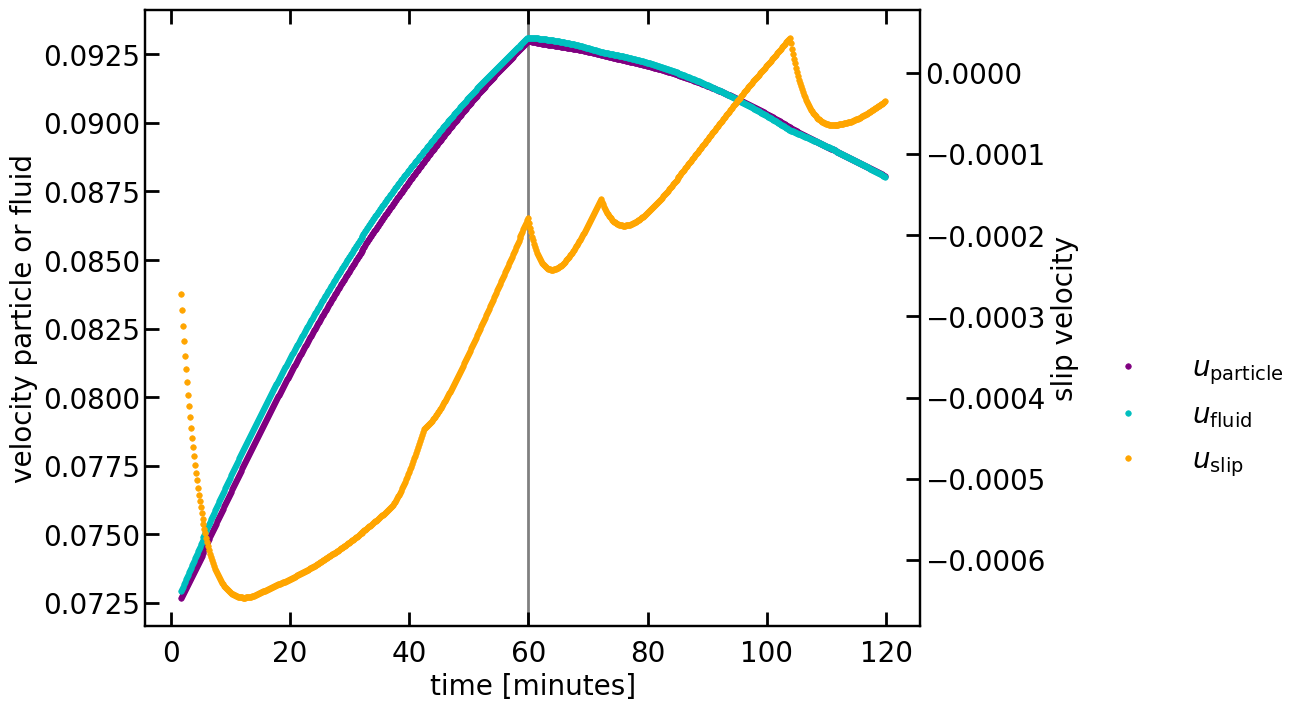

In [161]:
# plot values
id = 2
dt_write =10
fig,ax=plt.subplots()
for pt in ['inertial_Rep_constant']:
    
    ax.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].uparticle[id,10:],'.',color='purple')
    ax.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].ufluid[id,10:],'.',color='c')
    
    ax2 = ax.twinx()
    ax2.plot(data_short[pt][dt_write].time[id,10:]/60,data_short[pt][dt_write].uslip[id,10:],'.',color='orange')

ax.legend(['$u_{\\mathrm{particle}}$','$u_{\\mathrm{fluid}}$'],loc=(1.2,0.3))

ax2.legend(['$u_{\\mathrm{slip}}$'],loc=(1.2,0.22))

ax.set_ylabel('velocity particle or fluid')
ax2.set_ylabel('slip velocity')
ax.set_xlabel('time [minutes]')
ax.axvline(60,zorder=-5,color='grey')
# ax.set_yscale('log')


0.00047176034
9.2605475e-08



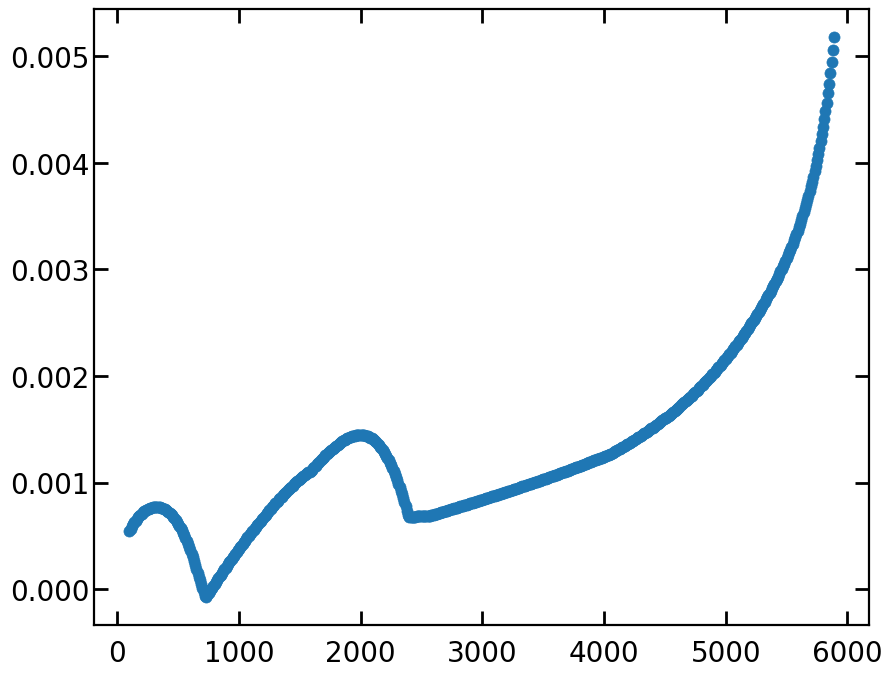

In [16]:
# calculating history term for 
id = 500
pt = 'inertial_drag_Rep'
ds = data_short[pt][dt_write].isel(trajectory=id)
Tend=(ds.time.ffill(dim='obs')[-1]-ds.time[0]).values
T = 6000
dt = dt = (ds.time[1]-ds.time[0]).values
N=int(T/dt)
time = np.arange(0,T+0.1*dt,dt)
y = ds.duslipdt[0:N+1].values
print(ds.uf[N].values)
print(y[N])
spl = CubicSpline(time, y)
time_new =np.arange(0,T,1)
y_new =spl(time_new)
Nnew=N*10


Nwindowlist = np.arange(10,N-10,1)
F_H_Nwindow = []
F_H_Nwindow_Dorgan = []
F_B_Nwindow = []
for Nwindow in Nwindowlist:


    # F_H = History_Force_Hinsberg_Mei_kernel(y[N-Nwindow-1:N+1],T,cs['Mei']['c1'],cs['Mei']['c2'],Rep,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    F_H = History_Force_Hinsberg_Mei_kernel(y[N-Nwindow-1:N+1],T,cs['Dorgan']['c1'],cs['Dorgan']['c2'],Rep,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    # F_B = History_Force_Hinsberg_Basset_kernel(y[N-Nwindow-1:N+1],T,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    F_H_Nwindow.append(F_H)
    # F_H_Nwindow_Dorgan.append(F_H_Dorgan)
    # F_B_Nwindow.append(F_B)

F_H_Nwindow = np.asarray(F_H_Nwindow)
# F_B_Nwindow = np.asarray(F_B_Nwindow)
# F_H_Nwindow_Dorgan = np.asarray(F_H_Nwindow_Dorgan)
Fdrag = slip_force(ds.uf,diameter,kinematic_viscosity_water,rho_water,Rep).values
print()
fig,ax=plt.subplots()
# ax.plot(Nwindowlist*dt,F_H_Nwindow,'o')
ax.plot(Nwindowlist*dt,F_H_Nwindow/Fdrag[N+1],'o')
# ax.plot(Nwindowlist*dt,F_B_Nwindow/Fdrag[N+1],'o')




0.23547058
2.6270476222038264


/tmp/ipykernel_92122/2316209632.py:4: RuntimeWarning: invalid value encountered in divide
  return tau_H * duslipdt/uslip


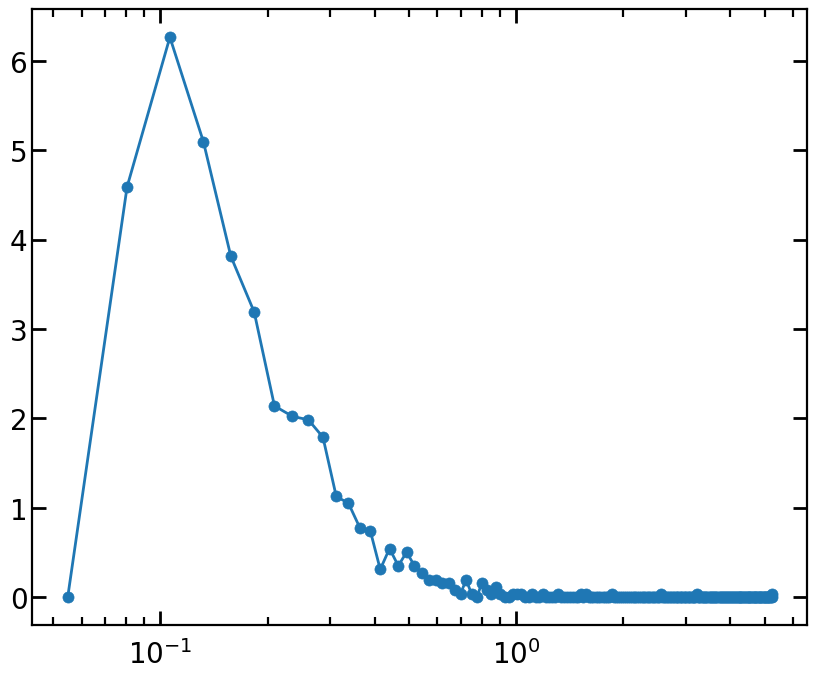

In [ ]:
# check criterium 
# tau_h * |duslip/dt| / |uslip| << 1 then history term negible
def history_number (duslipdt, uslip, tau_H):
    return tau_H * duslipdt/uslip
id = 0
dt_write=10

duslipdtmean = data_short['inertial_drag_Rep'][dt_write].duslipdt.pipe(abs).mean(dim='obs').values
uslipmean = data_short['inertial_drag_Rep'][dt_write].uf.pipe(abs).mean(dim='obs').values

history_number_per_particle = history_number(duslipdtmean,uslipmean,tau_H)
history_number_per_particle = history_number_per_particle[~np.isnan(history_number_per_particle)]
print(np.mean(history_number_per_particle))
bins,pdf = make_PDF(history_number_per_particle,nbins=200,norm=True)

fig,ax=plt.subplots()
# ax.plot(history_number(duslipdtmean,uslipmean,tau_H),'o')
# ax.set_yscale('log')
ax.set_xscale('log')
ax.plot(bins,pdf,'-o')
# history_number()

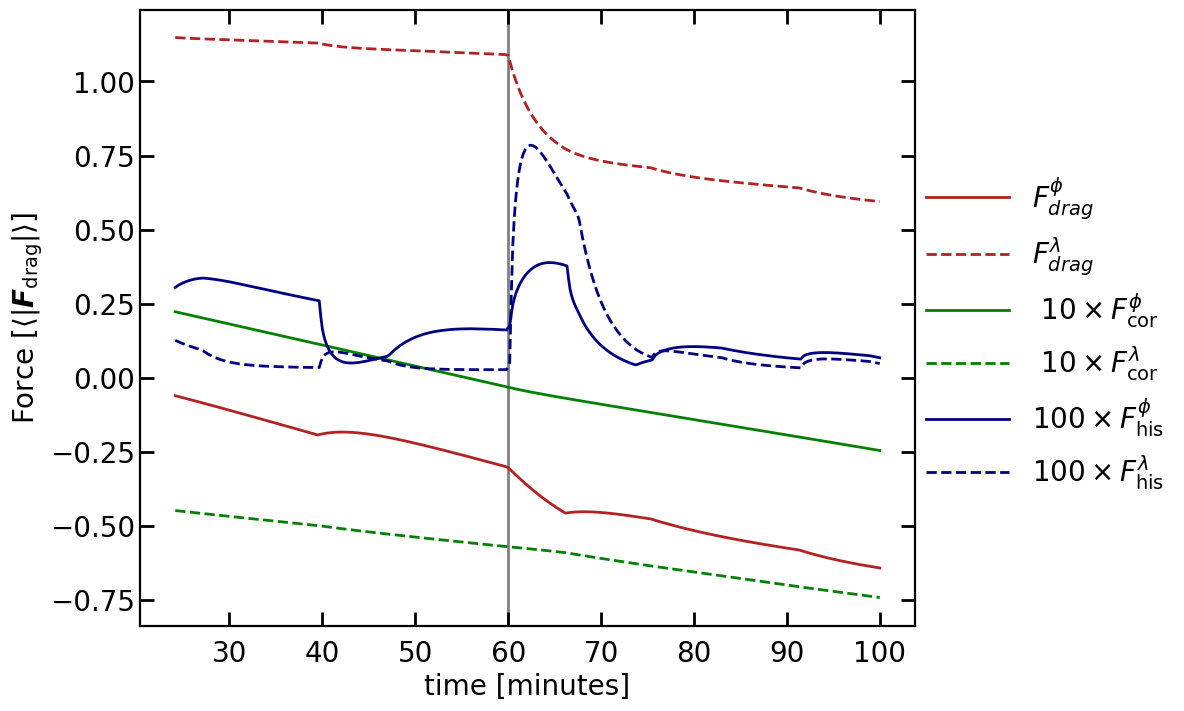

In [33]:
# calculating history term for 
id = 0
dt_write=10
pt = 'inertial_drag_Rep'
ds = data_short[pt][dt_write].isel(trajectory=id)
Tend=(ds.time.ffill(dim='obs')[-1]-ds.time[0]).values
T = 6000
dt = dt = (ds.time[1]-ds.time[0]).values
N=int(T/dt)
time = np.arange(0,T+0.1*dt,dt)
x = ds.duslipdt[0:N+1].values
y = ds.dvslipdt[0:N+1].values

Nwindow =  int(tau_H/dt)

Nwindowlist = np.arange(10,N-10,1)
F_H_v_Nwindow = []
F_H_u_Nwindow = []

for n in range(100+Nwindow,N,1):
    F_H_u = History_Force_Hinsberg_Mei_kernel(x[n-Nwindow-1:n+1],time[n+1],cs['Dorgan']['c1'],cs['Dorgan']['c2'],Rep,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    F_H_u_Nwindow.append(F_H_u)
    F_H_v = History_Force_Hinsberg_Mei_kernel(y[n-Nwindow-1:n+1],time[n+1],cs['Dorgan']['c1'],cs['Dorgan']['c2'],Rep,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    F_H_v_Nwindow.append(F_H_v)


F_H_u_Nwindow = np.asarray(F_H_u_Nwindow)
F_H_v_Nwindow = np.asarray(F_H_v_Nwindow)


Fdrag_u = slip_force(ds.uf,diameter,kinematic_viscosity_water,rho_water,Rep).values
Fdrag_v = slip_force(ds.vf,diameter,kinematic_viscosity_water,rho_water,Rep).values
norm =np.mean(np.sqrt(Fdrag_u[100+Nwindow+1:N+1]**2 + Fdrag_v[100+Nwindow+1:N+1]**2))

fig,ax=plt.subplots()

ax.plot(time[100+Nwindow+1:N+1]/60,Fdrag_u[100+Nwindow+1:N+1]/norm,'-',color='firebrick') 
ax.plot(time[100+Nwindow+1:N+1]/60,Fdrag_v[100+Nwindow+1:N+1]/norm,'--',color='firebrick') 

ax.plot(time[100+Nwindow+1:N+1]/60,10*ds.fcor_u[100+Nwindow+1:N+1]/norm,'-',color='green') 
ax.plot(time[100+Nwindow+1:N+1]/60,10*ds.fcor_v[100+Nwindow+1:N+1]/norm,'--',color='green') 

ax.plot(time[100+Nwindow+1:N+1]/60,100*F_H_u_Nwindow/norm,'-',color='navy') #Fdrag_u[100+Nwindow+1:N+1]
ax.plot(time[100+Nwindow+1:N+1]/60,100*F_H_v_Nwindow/norm,'--',color='navy') #/Fdrag_v[100+Nwindow+1:N+1]

ax.legend(['$F^{\\phi}_{drag}$','$F^{\\lambda}_{drag}$', ' $10 \\times F^{\\phi}_{\\mathrm{cor}}$', ' $10 \\times F^{\\lambda}_{\\mathrm{cor}}$',  '$100 \\times F^{\\phi}_{\\mathrm{his}}$','$100 \\times F^{\\lambda}_{\\mathrm{his}}$' ], loc = (1,0.2))
ax.set_xlabel('time [minutes]')
ax.set_ylabel('Force [$\\langle|\\boldsymbol{F}_{\\mathrm{drag}}|\\rangle$]')
# a bit suspisous that the lines are this straigt, but at least it is nice to show that 
# drag force = 10 x coriolis = 100 x history force
# does not even have to be completely correct but it would be an order of magnitude estimate 
# -> maybe also calculate effect on direction

# ax2=ax.twinx()
# up = ds.lon[101:N-5].values-ds.lon[100:N-6].values
# ax2.plot(time[101:N-5]/60,up,'o',color='orange')
# ax2.plot(time[100+Nwindow+1:N+1]/60,10*ds.lat[100+Nwindow+1:N+1],color='orange')


ax.axvline(60,color='grey',zorder=-10)

# 
